In [1]:
print('hi')

hi


In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)



In [3]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

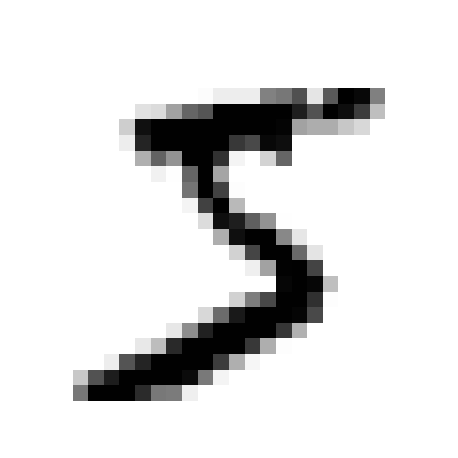

In [5]:
import matplotlib.pyplot as plt

X, y = mnist.data, mnist.target

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
save_fig("some_digit_plot")
plt.show()

In [6]:
y[0]

'5'

## Training a binary classifier

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

[ True]
[False] None


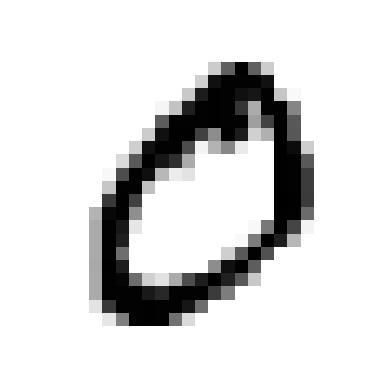

In [10]:
print(sgd_clf.predict([some_digit]))
print(sgd_clf.predict([X[1]]), plot_digit(X[1]))

## Performance measures

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

### Confusion Matrix

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

cm = confusion_matrix(y_train_5, y_train_pred)
cm


array([[53892,   687],
       [ 1891,  3530]])

### Precision and recall

In [13]:
from sklearn.metrics import precision_score, recall_score

ps = precision_score(y_train_5, y_train_pred)

rs = recall_score(y_train_5, y_train_pred)

print(ps, rs)

0.8370879772350012 0.6511713705958311


### F1 Score

In [14]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

### Precision Recall Trade off

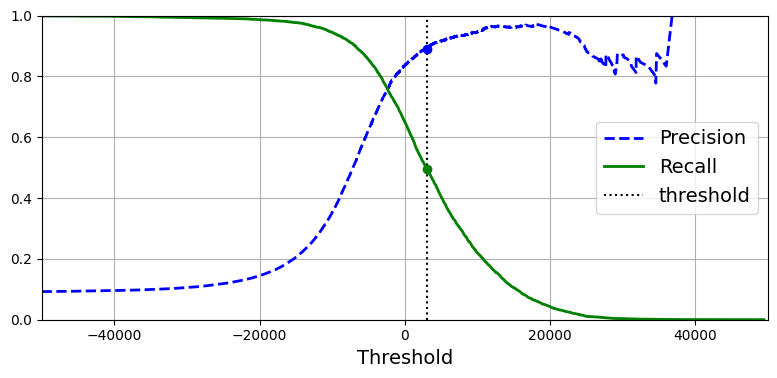

In [15]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function')

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
threshold = 3000

plt.figure(figsize=(8, 4))  
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")


idx = (thresholds >= threshold).argmax() 
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")

plt.show()

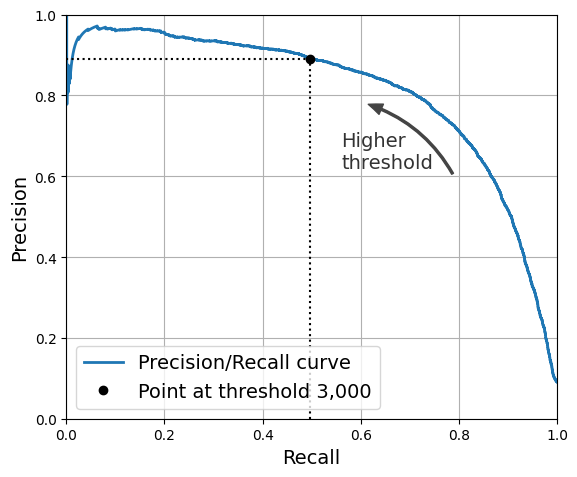

In [16]:
import matplotlib.patches as patches  

plt.figure(figsize=(6, 5)) 

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")


plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

In [17]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
ps_90 = precision_score(y_train_5, y_train_pred_90)
rs_90 = recall_score(y_train_5, y_train_pred_90)
print(ps_90, rs_90)

0.9000345901072293 0.4799852425751706


### ROC Curve

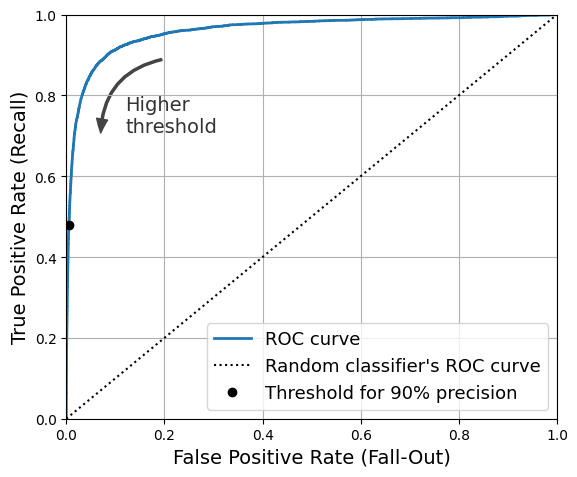

In [18]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5)) 
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")


plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

In [19]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

### Training RandomForestClassifier

In [20]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = 'predict_proba')
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

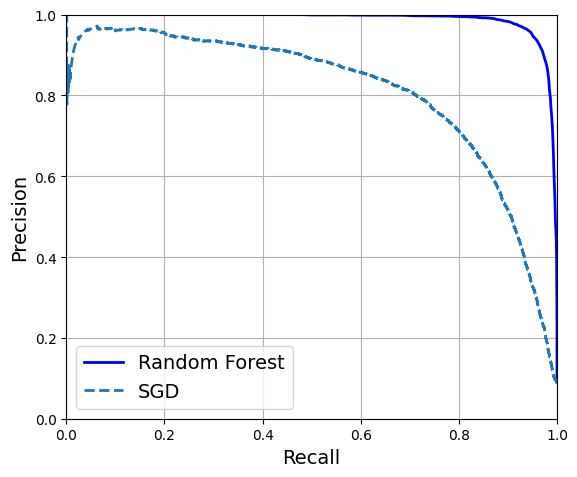

In [21]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

plt.figure(figsize=(6, 5)) 

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

### Confusion Matrix for multiclass classification

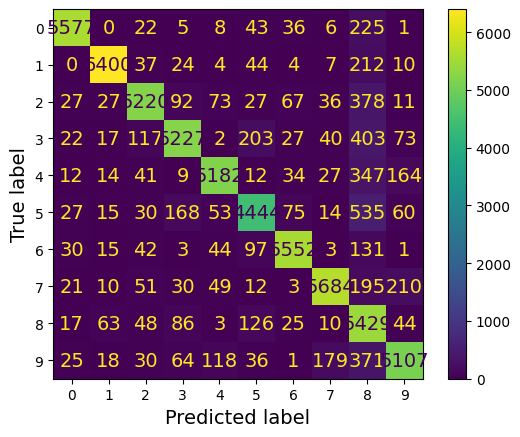

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype('float64'))

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

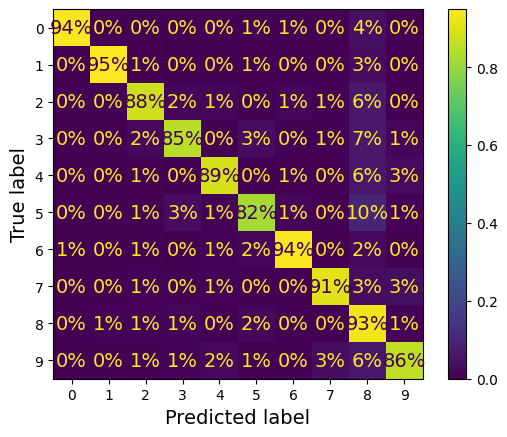

In [23]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize='true', values_format= ".0%")
plt.show()

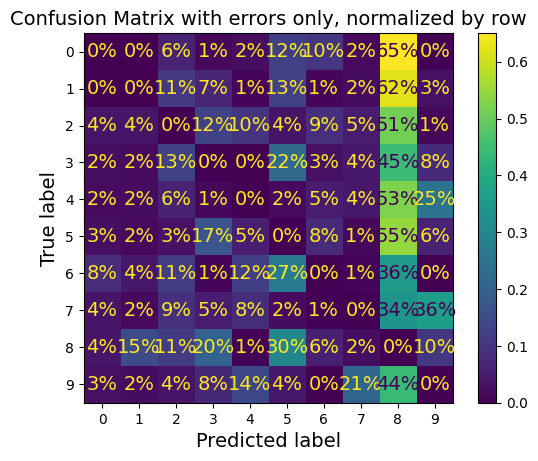

In [24]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize='true', values_format=".0%")
plt.title("Confusion Matrix with errors only, normalized by row")
plt.show()

## Multi Label Classification

In [25]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]])

### Evaluting Multi class

In [26]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score_multi = f1_score(y_multilabel, y_train_knn_pred, average='macro')
f1_score_multi

0.9764102655606048

### Chaining Classifiers

In [27]:
from sklearn.multioutput import ClassifierChain
from sklearn.svm import SVC

chain_clf = ClassifierChain(SVC(), cv = 3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

chain_clf.predict([some_digit])

array([[0., 1.]])

### Multi Class Multi Label Classification (Multi output classfication)

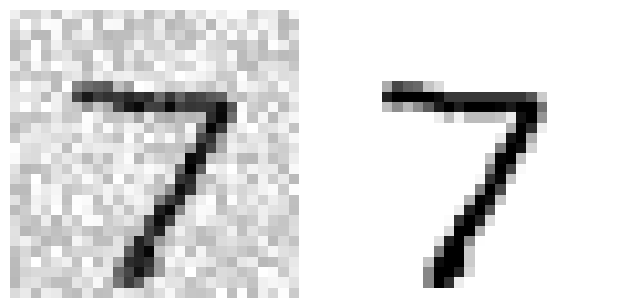

In [28]:
np.random.seed(42) 
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
save_fig("noisy_digit_example_plot")
plt.show()

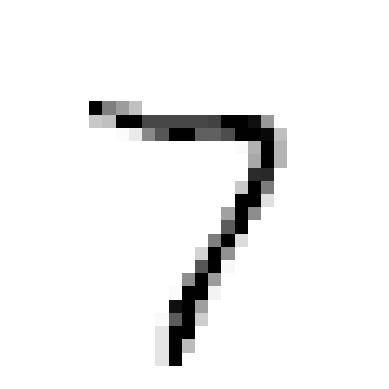

In [29]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()